# Tracer Advection Stencil

#### 1. Start a parallel cluster

In [1]:
from functions import show_clusters

import ipyparallel as ipp
import time

cluster = ipp.Cluster(engines='mpi', n=6).start_and_connect_sync()


Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

In [2]:
time.sleep(15)
show_clusters()

cluster_id        state    cluster_file
1657836418-enmz  running   /home/ajdas/.ipython/profile_default/security/cluster-1657836418-enmz.json


In [3]:
%autopx

%autopx enabled


#### 2. Configure the domain

In [6]:
%%capture
from mpi4py import MPI
import functions as func
import importlib
importlib.reload(func)


mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

backend = 'numpy'
layout = (1, 1)
nx, ny, nz, nhalo = 100, 100, 79, 3
dimensions = {'nx': nx, 'ny': ny, 'nx1': nx+1, 'ny1': ny+1, 'nz': nz, 'nhalo': nhalo, 'tile': mpi_size, 'nxhalo': nx+2*nhalo, 'nyhalo': ny+2*nhalo}
units = {'dist': 'm', 'coord': 'degrees', 'qvapor': 'kg/kg', 'psi': 'kg/m/s', 'wind': 'm/s', 'courant': '', 'areaflux': 'm2', 'qflux': 'kg/m2', 'pressure': 'Pa'}
origins = {'halo': (0, 0), 'compute_2d': (dimensions['nhalo'], dimensions['nhalo']), 'compute_3d': (dimensions['nhalo'], dimensions['nhalo'], 0)}


configuration = func.configure_domain(layout, mpi_comm, dimensions, backend=backend)

#### 2a. Gather domain coordinates

In [7]:
from pace.util import Quantity
import numpy as np

dx_halo =  Quantity(configuration['grid_data'].dx.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dy_halo =  Quantity(configuration['grid_data'].dy.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dxa_halo =  Quantity(configuration['grid_data'].dxa.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dya_halo =  Quantity(configuration['grid_data'].dya.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dxc_halo =  Quantity(configuration['grid_data'].dxc.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dyc_halo =  Quantity(configuration['grid_data'].dyc.data, ('x_halo', 'y_halo'), units['dist'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
dx_global = configuration['communicator'].gather(dx_halo)
dy_global = configuration['communicator'].gather(dy_halo)
dxa_global = configuration['communicator'].gather(dxa_halo)
dya_global = configuration['communicator'].gather(dya_halo)
dxc_global = configuration['communicator'].gather(dxc_halo)
dyc_global = configuration['communicator'].gather(dyc_halo)

lona_halo =  Quantity(configuration['grid_data'].lon_agrid.data * 180 / np.pi, ('x_halo', 'y_halo'), units['coord'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
lata_halo =  Quantity(configuration['grid_data'].lat_agrid.data * 180 / np.pi, ('x_halo', 'y_halo'), units['coord'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
lona_global = configuration['communicator'].gather(lona_halo)
lata_global = configuration['communicator'].gather(lata_halo)

#### 2b. Save coordinates to netCDF file

Convert below markdown cell to code.

```
import functions as func


lon_halo =  Quantity(configuration['grid_data'].lon.data * 180 / np.pi, ('x_halo', 'y_halo'), units['coord'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
lat_halo =  Quantity(configuration['grid_data'].lat.data * 180 / np.pi, ('x_halo', 'y_halo'), units['coord'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)


lon_global = configuration['communicator'].gather(lon_halo)
lat_global = configuration['communicator'].gather(lat_halo)

fOut = 'coordinates.nc'
variables = {'dx': dx_global, 'dy': dy_global, 
             'dxa': dxa_global, 'dya': dya_global, 
             'dxc': dxc_global, 'dyc': dyc_global, 
             'lon': lon_global, 'lat': lat_global, 
             'lona': lona_global, 'lata': lata_global}

if mpi_rank == 0:
    func.store_coordinates(fOut, dimensions, variables)
```

#### 3. Create initial conditions on a plane

#### 3a. Create water vapor initial condition

In [40]:
if mpi_rank == 0:
    gaussian_multiplier = func.create_gaussianMultiplier(np.deg2rad(lona_global.data), np.deg2rad(lata_global.data), dimensions, center_tile=0)
else:
    gaussian_multiplier = np.zeros((dimensions['tile'], dimensions['nxhalo'], dimensions['nyhalo']))

mpi_comm.Bcast(gaussian_multiplier, root=0)
qvapor_2d = Quantity(gaussian_multiplier[mpi_rank], ('x', 'y'), units['qvapor'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)
qvapor_global = configuration['communicator'].gather(qvapor_2d)

[stdout:0] Centering gaussian on lon=351.01, lat=1.01


#### 3b. Run coordinates through streamfunction generation

In [41]:
psi, psi_staggered = func.calculate_streamfunction_testCase1(np.deg2rad(lona_halo.data), np.deg2rad(lata_halo.data), dimensions)

psi_halo = Quantity(psi, ('x_halo', 'y_halo'), units['psi'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
psi = Quantity(psi, ('x', 'y'), units['psi'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)
psi_staggered_halo = Quantity(psi_staggered, ('x_halo', 'y_halo'), units['psi'], origins['halo'], (dimensions['nxhalo'], dimensions['nyhalo']), backend)
psi_staggered  = Quantity(psi_staggered, ('x_interface', 'y_interface'), units['psi'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)

psi_global = configuration['communicator'].gather(psi)
psi_staggered_global = configuration['communicator'].gather(psi_staggered)

#### 3c. Calculate winds from streamfunction

`ua`, `va` - winds on cell centers
`uc`, `vc` - covariant winds on C-grid

In [42]:
ua, va = func.calculate_windsFromStreamfunction_grid(psi_halo, dxa_halo, dya_halo, dimensions, grid='A')

ua_2d = Quantity(ua, ('x', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)
va_2d = Quantity(va, ('x', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny']), backend)

ua_global = configuration['communicator'].gather(ua_2d)
va_global = configuration['communicator'].gather(va_2d)

In [43]:
uc, vc = func.calculate_windsFromStreamfunction_grid(psi_staggered_halo, dx_halo, dy_halo, dimensions, grid='C')

uc_2d = Quantity(uc, ('x', 'y_interface'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny1']), backend)
vc_2d = Quantity(vc, ('x_interface', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny']), backend)

uc_global = configuration['communicator'].gather(uc_2d)
vc_global = configuration['communicator'].gather(vc_2d)

In [44]:
ud, vd = func.calculate_windsFromStreamfunction_grid(psi_halo, dx_halo, dy_halo, dimensions, grid='D')

ud_2d = Quantity(ud, ('x_interface', 'y'), units['wind'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny']), backend)
vd_2d = Quantity(vd, ('x', 'y_interface'), units['wind'], origins['compute_2d'], (dimensions['nx'], dimensions['ny1']), backend)

ud_global = configuration['communicator'].gather(ud_2d)
vd_global = configuration['communicator'].gather(vd_2d)

#### 3d. Find pressure distribution consistent with velocity field ?????

$$
\nabla ^2 p = 2 \rho \left[ \frac{\partial u}{\partial x} \frac{\partial v}{\partial y} - \frac{\partial v}{\partial x} \frac{\partial u}{\partial y} \right]
$$

#### 3d. Plot initial conditions and save data to file
To show plotted images, uncomment the second cell below

In [45]:
# %%capture capt --no-stderr --no-stdout
# fOut = 'initialize_winds.nc'

# lona =  Quantity(configuration['grid_data'].lon_agrid.data * 180 / np.pi, ('x_interface', 'y_interface'), units['coord'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)
# lata =  Quantity(configuration['grid_data'].lat_agrid.data * 180 / np.pi, ('x_interface', 'y_interface'), units['coord'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)
# lon_global = configuration['communicator'].gather(lona)
# lat_global = configuration['communicator'].gather(lata)

# if mpi_rank == 0:
#     variables = {'lon': lon_global.data, 'lat': lat_global.data, 'ua': ua_global.data, 'va': va_global.data, 'psi': psi_global.data, 'qvapor': qvapor_global.data}

#     func.plot_projection_field(variables['lon'], variables['lat'], variables['qvapor'], vmin=-0, vmax=1, cmap='viridis', title='q_vapor init', units=units['qvapor'])
#     func.plot_projection_field(variables['lon'], variables['lat'], variables['ua'], vmin=-40, vmax=40, cmap='bwr', title='ua init', units=units['wind'])
#     func.plot_projection_field(variables['lon'], variables['lat'], variables['va'], vmin=-40, vmax=40, cmap='bwr', title='va init', units=units['wind'])
#     func.plot_projection_field(variables['lon'], variables['lat'], variables['psi'], vmin=-3e8, vmax=3e8, cmap='bwr', title='psi init', units=units['psi'])

#     func.write_initialCondition_toFile(fOut, variables, dimensions, units)

In [46]:
# capt()

#### 4. Prepare flux stencil

#### 4a. Extend initial conditions into the vertical

In [48]:
dimensions['nz'] = 1

empty = np.zeros((dimensions['nxhalo']+1, dimensions['nyhalo']+1, dimensions['nz']+1))

qvapor_3d = np.copy(empty)
uc_3d = np.copy(empty)
vc_3d = np.copy(empty)
qvapor_3d[:-1, :-1, 0] = qvapor_2d.data
uc_3d[:-1, :-1, 0] = uc_2d.data
vc_3d[:-1, :-1, 0] = vc_2d.data

qvapor = Quantity(qvapor_3d, ('x', 'y', 'z'), units['qvapor'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)
qvapor_init = Quantity(qvapor_3d, ('x', 'y', 'z'), units['qvapor'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)
uc = Quantity(uc_3d, ('x', 'y_interface', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)
vc = Quantity(vc_3d, ('x_interface', 'y', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)

#### 4b. Prepare data for flux calculation

- use the function `FiniteVolumeFluxPrep`
    - requires `uc` and `vc` from (3c). 
    - requires some empty arrays to be filled in:
        - `crx` and `cry` are the dimensionless Courant numbers on C-grid points.
        - `xaf` and `yaf` are are fluxes of area in m2.
        - `ucc` and `vcc` are the contravariant velocities on C-grid points
        - `dt` is the acoustic time step.

In [50]:
%%capture capt
from fv3core.stencils.fxadv import FiniteVolumeFluxPrep

fvf_prep = FiniteVolumeFluxPrep(configuration['stencil_factory'], configuration['grid_data'])

crx = Quantity(empty, ('x_interface', 'y', 'z'), units['courant'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
cry = Quantity(empty, ('x', 'y_interface', 'z'), units['courant'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)

xaf = Quantity(empty, ('x_interface', 'y', 'z'), units['areaflux'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
yaf = Quantity(empty, ('x', 'y_interface', 'z'), units['areaflux'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)

ucv = Quantity(empty, ('x_interface', 'y', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)
vcv = Quantity(empty, ('x', 'y_interface', 'z'), units['wind'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)


dt_acoustic = 300.

fvfp = fvf_prep(uc, vc, crx, cry, xaf, yaf, ucv, vcv, dt_acoustic)

print()
print('UC min, mean, max: %.2f %.2f %.2f' % (np.nanmin(uc), np.nanmean(uc), np.nanmax(uc)))
print('UCV min, mean, max: %.2f %.2f %.2f' % (np.nanmin(ucv), np.nanmean(ucv), np.nanmax(ucv)))
print()
print('VC min, mean, max: %.2f %.2f %.2f' % (np.nanmin(vc), np.nanmean(vc), np.nanmax(vc)))
print('VCV min, mean, max: %.2f %.2f %.2f' % (np.nanmin(vcv), np.nanmean(vcv), np.nanmax(vcv)))
print()
print('X-Courant min, mean, max: %.2f %.2f %.2f' % (np.nanmin(crx), np.nanmean(crx), np.nanmax(crx)))
print('Y-Courant min, mean, max: %.2f %.2f %.2f' % (np.nanmin(cry), np.nanmean(cry), np.nanmax(cry)))
print()
print('X-area flux min, mean, max: %.2f %.2f %.2f' % (np.nanmin(xaf), np.nanmean(xaf), np.nanmax(xaf)))
print('X-area flux min, mean, max: %.2f %.2f %.2f' % (np.nanmin(yaf), np.nanmean(yaf), np.nanmax(yaf)))

#### (4c) Hack mass flux?

xaf is the flux of area in x direction (dx*dy)
yaf is the flux of area in y direction (dx*dy)

to get mass flux -- 
for now -- assume mass flux is area flux.

#### (4d) Create finite volume transport stencil

- use the function `FiniteVolumeTransport` 
    - takes in the tracer `qvap` to be transported.
    - takes in the `crx` and `cry` Courant numbers, `xaf` and `yaf` area fluxes from previous step.
    - requires some empty arrays to be filled in:
        - `qfx` and `qfy` are the output fluxes of the tracer to be transported -- i think kg/m2?
        
- also takes in mass fluxes (optional) -- where would I find those?

- do I actually need the `qfx`, `qfy` that are output? I don't think so ...

In [73]:
%%capture capt
from fv3core.stencils.fvtp2d import FiniteVolumeTransport

grid_type = 0
hord = 6

qfx = Quantity(empty, ('x', 'y_interface', 'z'), units['qflux'], origins['compute_3d'], (dimensions['nx'], dimensions['ny1'], dimensions['nz']), backend)
qfy = Quantity(empty, ('x_interface', 'y', 'z'), units['qflux'], origins['compute_3d'], (dimensions['nx1'], dimensions['ny'], dimensions['nz']), backend)

tracers = {'qvapor': qvapor}

fvtp2d = FiniteVolumeTransport(configuration['stencil_factory'], configuration['grid_data'], configuration['damping_coefficients'], grid_type, hord)
fvTransport = fvtp2d(tracers['qvapor'], crx, cry, xaf, yaf, qfx, qfy)

print('Q-flux-x min, mean, max: %.2f %.2f %.2f' % (np.nanmin(qfx), np.nanmean(qfx), np.nanmax(qfx)))
print('Q-flux-y min, mean, max: %.2f %.2f %.2f' % (np.nanmin(qfy), np.nanmean(qfy), np.nanmax(qfy)))

delp = Quantity(np.ones(empty.shape)*1000, ('x', 'y', 'z'), units['pressure'], origins['compute_3d'], (dimensions['nx'], dimensions['ny'], dimensions['nz']), backend)

#### 5. Perform tracer advection

In [74]:
#%%capture capt
from fv3core.stencils.tracer_2d_1l import TracerAdvection

import copy as cp

tracAdv = TracerAdvection(configuration['stencil_factory'], fvtp2d, configuration['grid_data'], configuration['communicator'], tracers)
nSteps_adv = 10

dt = 1200.

crx_init = cp.deepcopy(crx)
cry_init = cp.deepcopy(cry)
for step in range(nSteps_adv):
    tmp = cp.deepcopy(tracers) # get pre-step value
    adv = tracAdv(tracers, delp, xaf, yaf, crx, cry, dt)

    crx = cp.deepcopy(crx_init)
    cry = cp.deepcopy(cry_init)

    diff = tracers['qvapor'].data - tmp['qvapor'].data

    print()
    print('Step %s tracers |differece| min, mean, max: %.2e %.2e %.2e' % (step, np.nanmin(diff), np.nanmean(diff), np.nanmax(diff)))

[stdout:2] 
Step 0 tracers |differece| min, mean, max: -2.84e-270 -1.65e-274 3.70e-273

Step 1 tracers |differece| min, mean, max: -1.89e-270 -8.27e-275 3.28e-288

Step 2 tracers |differece| min, mean, max: -1.04e-317 2.97e-317 6.79e-313

Step 3 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 4 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 5 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 6 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 7 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 8 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 9 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00


[stdout:3] 
Step 0 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 1 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 2 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 3 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 4 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 5 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 6 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 7 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 8 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 9 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00


[stdout:4] 
Step 0 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 1 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 2 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 3 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 4 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 5 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 6 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 7 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 8 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 9 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00


[stdout:0] 
Step 0 tracers |differece| min, mean, max: 0.00e+00 6.78e-271 7.75e-267

Step 1 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 2 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 3 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 4 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 5 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 6 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 7 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 8 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 9 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00


[stdout:1] 
Step 0 tracers |differece| min, mean, max: -3.60e-240 2.95e-235 3.86e-231

Step 1 tracers |differece| min, mean, max: -7.44e-265 3.08e-267 2.38e-263

Step 2 tracers |differece| min, mean, max: -4.73e-271 -2.07e-275 5.73e-298

Step 3 tracers |differece| min, mean, max: -1.55e-317 2.05e-320 2.49e-316

Step 4 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 5 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 6 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 7 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 8 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 9 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00


[stdout:5] 
Step 0 tracers |differece| min, mean, max: -6.61e-280 6.83e-271 7.75e-267

Step 1 tracers |differece| min, mean, max: -7.47e-301 5.74e-291 1.31e-286

Step 2 tracers |differece| min, mean, max: 0.00e+00 1.15e-291 2.63e-287

Step 3 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 4 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 5 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 6 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 7 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 8 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00

Step 9 tracers |differece| min, mean, max: 0.00e+00 0.00e+00 0.00e+00


In [61]:
lona =  Quantity(configuration['grid_data'].lon_agrid.data * 180 / np.pi, ('x_interface', 'y_interface'), units['coord'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)
lata =  Quantity(configuration['grid_data'].lat_agrid.data * 180 / np.pi, ('x_interface', 'y_interface'), units['coord'], origins['compute_2d'], (dimensions['nx1'], dimensions['ny1']), backend)
lon_global = configuration['communicator'].gather(lona)
lat_global = configuration['communicator'].gather(lata)

In [62]:
qvapor_init = configuration['communicator'].gather(qvapor_init)
qvapor_final = configuration['communicator'].gather(qvapor)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

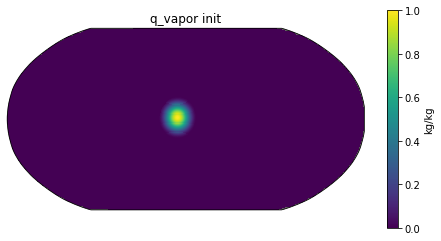

[output:0]

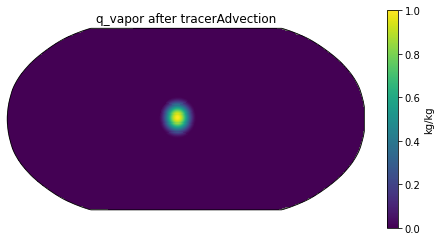

[output:0]

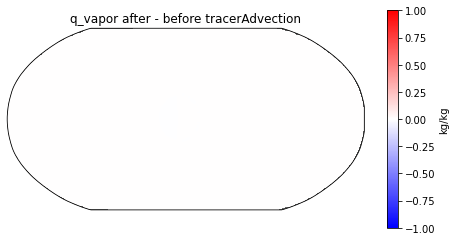

In [72]:
if mpi_rank == 0:
    variables = {'lon': lon_global.data, 'lat': lat_global.data, 'q_start': qvapor_init.data[:, :, :, 0], 'q_end': qvapor_final.data[:, :, :, 0]}
    #func.plot_projection_field(variables['lon'], variables['lat'], variables['q_start'], vmin=-0, vmax=1, cmap='viridis', title='q_vapor init', units=units['qvapor'])
    #func.plot_projection_field(variables['lon'], variables['lat'], variables['q_end'], vmin=-0, vmax=1, cmap='viridis', title='q_vapor after tracerAdvection', units=units['qvapor'])
    func.plot_projection_field(variables['lon'], variables['lat'], variables['q_end'] - variables['q_start'], vmin=-1, vmax=1, cmap='bwr', title='q_vapor after - before tracerAdvection', units=units['qvapor'])